In [2]:
import pandas as pd
#from preprocessing import * # this will not work in Jupyter
from gensim.test.utils import get_tmpfile
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import pickle

from gensim.parsing.preprocessing import preprocess_string
import re
import string
import random


from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import strip_multiple_whitespaces
from gensim.parsing.preprocessing import stem_text
from gensim.parsing.preprocessing import strip_numeric

# new from this notebook
import numpy as np
# Let's look at making the FAQ list better
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import MeanShift

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
### Read in the data
#
#
#ticket_dat_all = pd.read_csv('../data/11-28-first_ticket_dat.csv')
#ticket_dat_all= pd.read_csv('../data/11-28-first2_ticket_dat.csv')
ticket_dat_all= pd.read_csv('../data/11-28-first3_ticket_dat.csv')
#ticket_dat_all = pd.read_csv('../data/11-24-ticket_dat.csv')
faq_dat = pd.read_csv('../data/11-24-faq_dat_cleaned.csv')

# Replace the NaNs
ticket_dat_all.fillna('', inplace=True)
faq_dat.fillna('', inplace=True)

# Replace the NaNs
ticket_dat_all.dropna()
faq_dat.dropna()

# Make sentences into lists
faq_ques = list(faq_dat.question)
n_faq_ques = len(faq_ques)

faq_ans = list(faq_dat.answer_title + " " + faq_dat.answer)
n_faq_ans = len(faq_ans)

ticket_ques = list(ticket_dat_all.question)
n_ticket_ques = len(ticket_ques)

ticket_ans = list(ticket_dat_all.answer)
n_ticket_ans = len(ticket_ans)

# Taking off FAQ duplicates / blanks
Skip if already done

In [15]:
### Create TF-IDF vectorisation on FAQ list to remove duplicates
#
#
# initialise model
vectoriser = TfidfVectorizer(strip_accents='unicode', lowercase=True,analyzer='word')
# create matrix: rows = FAQ ans; cols = TI-IDF weighted word vector
matrix = vectoriser.fit_transform(faq_ans)
print(matrix.shape, len(faq_ans))
# ans with na (389, 2375) 389

(277, 2241) 277


In [16]:
# calculate pairwise similarities
sim_matrix = cosine_similarity(matrix)

# deleting diagonal as all vecs will have a 100% similarity
for i in range(len(sim_matrix)):
    sim_matrix[i,i] = 0

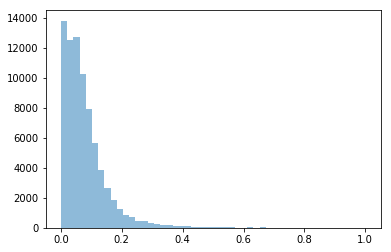

271.0


In [17]:
# VISUALISATION: visualise distribution
bins =  np.linspace(0, 1,50)
plt.hist(np.reshape(sim_matrix, (-1)), bins,alpha=.5)
plt.show()
# calculate high similaries
# divide by two because of double counting
print(np.sum(sim_matrix>0.4)/2)

In [18]:
# take duplicates - empirically (looking at example) decided to go for
# cosine similarity above 0.735 is a duplicate
# 0.735 
# determine the indices for large similarity
[a, b] = np.nonzero(sim_matrix>0.735)
# we'll only need to take off one of the two duplicates from the faq list
newa = a[a<b]
newb = b[a<b]

# DEBUG
new_sim_matrix = np.copy(sim_matrix)
new_sim_matrix[a,b] = 0

In [19]:
# DEBUG: Check largest remaining index
# undo commenting prints if curious
#
# Get a feel for the data we are deleting
print(newa,'\n\n',newb,'\n\n', len(newa), len(newb))

[] 

 [] 

 0 0


In [58]:
# DEBUG: Check largest remaining index
# undo commenting prints if curious
#
ind = np.unravel_index(np.argmax(new_sim_matrix), (np.shape(new_sim_matrix)))
#print('Index of largest similarity', ind)
#print('Largest similarity value',np.max(new_sim_matrix),'\n')

# Look at FAQ to check
#print(faq_ans[ind[0]],"\n\n", faq_ans[ind[1]])

In [59]:
# DEBUG: 
# undo commenting prints if curious
#
# The next boxes are for when I tried to do this manually. Eventually settled for an approximate way
# case A: this is a duplicate
newa = np.append(newa, [ind[0]]) 
newb = np.append(newb, [ind[1]])
#print(newa,'\n\n',newb,'\n\n', len(newa), len(newb))
new_sim_matrix[ind] = 0
new_sim_matrix[ind[1], ind[0]] = 0

In [60]:
# DEBUG: 
# undo commenting prints if curious
#
# The next boxes are for when I tried to do this manually. Eventually settled for an approximate way
# case B: this is a duplicate of a duplicate
newa = np.append(newa, ind)
#print(newa,'\n\n',newb,'\n\n', len(newa), len(newb))
new_sim_matrix[ind] = 0
new_sim_matrix[ind[1], ind[0]] = 0

In [160]:
# DEBUG: 
# undo commenting prints if curious
#
# The next boxes are for when I tried to do this manually. Eventually settled for an approximate way
# case C: this is not a duplicate
new_sim_matrix[ind] = 0
new_sim_matrix[ind[1], ind[0]] = 0

In [64]:
# Add the empty FAQ ans to the list of indices to remove
newb = np.unique(np.sort(np.concatenate((newb,np.nonzero(np.sum(matrix, axis=1)==0)[0]))))
newb

array([ 33,  34,  35,  36,  72,  73,  76, 106, 109, 110, 114, 124, 135,
       136, 145, 146, 147, 149, 171, 174, 178, 183, 188, 190, 192, 198,
       200, 205, 206, 211, 218, 228, 232, 233, 234, 235, 236, 239, 240,
       243, 244, 245, 246, 247, 249, 250, 251, 252, 254, 255, 256, 257,
       262, 269, 271, 273, 275, 276, 277, 278, 279, 280, 281, 282, 283,
       284, 285, 289, 290, 291, 298, 299, 300, 301, 302, 303, 304, 305,
       307, 308, 309, 314, 315, 317, 318, 327, 329, 330, 331, 332, 333,
       334, 335, 337, 338, 340, 341, 342, 343, 344, 345, 350, 355, 361,
       365, 366, 374, 376, 383, 384, 385, 388])

In [61]:
## DELETING DUPLICATES & empty FAQs, SAVING
# NOTE: please take care to only run this command once
faq_dat2 = faq_dat.drop(newb, axis=0)
faq_dat2.to_csv('../data/11-24-faq_dat_cleaned.csv')

# Make sentences back into lists
faq_ques = list(faq_dat2.question)
n_faq_ques = len(faq_ques)

faq_ans = list(faq_dat2.answer_title + " " + faq_dat2.answer)
n_faq_ans = len(faq_ans)
print(len(faq_ques))

277


In [67]:
faq_dat3 = pd.read_csv('../data/11-24-faq_dat_cleaned.csv')
print(len(faq_dat2), len(faq_dat3))

277 277


# Taking off blanks in tickets

In [36]:
# Train model:
temp = TfidfVectorizer(strip_accents='unicode', lowercase=True,analyzer='word')
all_tix = list(ticket_ques)+ list(ticket_ans)
temp.fit(all_tix)
temp_mat_ans = temp.transform(ticket_ans)
temp_mat_ques = temp.transform(ticket_ques)
# Find empty embeddings:
[xind_ans, yind] = np.nonzero(np.sum(temp_mat_ans, axis=1)==0)
print('tixind',len(xind_ans))#,'check', ticket_ans[xind_ans[0]])

[xind_ques, yind] = np.nonzero(np.sum(temp_mat_ques, axis=1)==0)
print('tixind',len(xind_ques),'check', ticket_ques[xind_ques[0]])

print('n_ticket_ans',n_ticket_ans,'\nn_ticket_ques',n_ticket_ques)

tixind 754
tixind 63 check 

n_ticket_ans 5004 
n_ticket_ques 5004


In [37]:
ticket_dat2 = ticket_dat_all.drop(list(xind_ques) + list(xind_ans), axis=0)
ticket_dat2.to_csv('../data/11-29-first3_ticket_dat.csv')

# Now we can move on to the model

In [3]:
# Use same TF-IDF model as above
# initialise model
vectoriser2 = TfidfVectorizer(strip_accents='unicode', lowercase=True,analyzer='word')
# create matrix: rows = all ans; cols = TI-IDF weighted word vector
all_ans = list(faq_ans) + list(ticket_ans)
m2 = vectoriser2.fit_transform(all_ans)
# DEBUG:
print(m2.shape, len(faq_ans), len(ticket_ans), len(all_ans))

(5393, 11975) 389 5004 5393


In [4]:
# DELETE BLANKS
# this is a slightly convoluted way of doing so, 
#but it will delete all blanks / blanks with a dot / blanks with an empty space etc due to the preprocessing
[tixind, yind] = np.nonzero(np.sum(m2[len(faq_ans):,:], axis=1)==0)
print('tixind',len(tixind), ticket_ans[tixind[0]])
print('n_ticket_ans',n_ticket_ans,'\nn_ticket_ques',n_ticket_ques)

tixind 787 
n_ticket_ans 5004 
n_ticket_ques 5004


In [5]:
## DELETING EMPTY SLOTS & SAVING
# NOTE: please take care to only run this command once
ticket_dat2 = ticket_dat.drop(tixind, axis=0)
ticket_dat2.to_csv('../data/11-24-first_ticket_dat.csv')

ticket_ques = list(ticket_dat2.question)
n_ticket_ques = len(ticket_ques)

ticket_ans = list(ticket_dat2.answer)
n_ticket_ans = len(ticket_ans)

In [7]:
# DEBUG: 
# undo commenting prints if curious
#
print('n_faq_ans',n_faq_ans,'\nn_faq_ques',n_faq_ques)
print('n_ticket_ans',n_ticket_ans,'\nn_ticket_ques',n_ticket_ques)

n_faq_ans 389 
n_faq_ques 389
n_ticket_ans 4217 
n_ticket_ques 4217


In [9]:
# SAVING MATERIAL
removal_dict = {
#        'removed_faq': newb,
        'removed_ticket': tixind
    }
with open('../data/11-24-first_removed.pkl', "wb") as fp:
    pickle.dump(removal_dict, fp)

In [10]:
# Retrain after deleting some pieces
# Use same TF-IDF model as above
# initialise model
vectoriser2 = TfidfVectorizer(strip_accents='unicode', lowercase=True,analyzer='word')
# create matrix: rows = all ans; cols = TI-IDF weighted word vector
all_ans = list(faq_ans) + list(ticket_ans)
m2 = vectoriser2.fit_transform(all_ans)
# DEBUG:
print(m2.shape, len(faq_ans), len(ticket_ans), len(all_ans))

(4606, 11975) 389 4217 4606


In [11]:
# Calculate similarities between faq ans and ticket ans
SM = cosine_similarity(m2[:len(faq_ans),:], m2[len(faq_ans):,:])

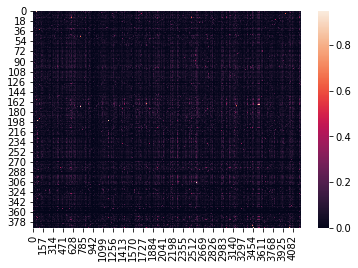

In [12]:
# VISUALISATION: heatmap of the similarity matrix
sns.heatmap(SM)
plt.show()

In [14]:
# VISUALISATION
# Check stringest similarity
ind = np.unravel_index(np.argmax(SM), (np.shape(SM)))
print('Index of largest similarity', ind)
print('Largest similarity value',np.max(SM),'\n')

# Look at FAQ to check and ticket
print('FAQ\t',faq_ans[ind[0]],"\n\ntix\t", ticket_ans[ind[1]])

print("Looks good (at least for the very best result ;) )")

Index of largest similarity (49, 869)
Largest similarity value 0.9468283043927097 

FAQ	 Manual office activation  To activate office manually the following steps are required:Run a Command promt as adminstratorUse the command "cd" to get in the folder in which office is installed c:\Programm files\Microsoft Office\Office14 (The path can variate)Now send the following commands:cscript OSPP.VBS /remhst (removes the activationserver)cscript OSPP.VBS /sethst:kms1.ethz.ch (sets the activationserver)cscript OSPP.VBS /act (starts the activation)After that the product should be activated and you should get confirmation.Please restart your office to finish the activation. 

tix	 Dear Ms. Dr. Anna Beltzung 

Maybe you have to activate the office manually. To activate office manually
the following steps are required:

 - Run a Command promt as adminstrator 
 - Use the command "cd" to get in the folder in which office is installed
c:\Programm files\Microsoft Office\Office14 (The path can variate)

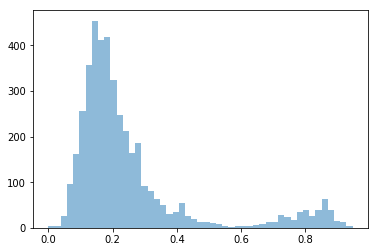

I like this graph because it is a good metric of how well our similarity method works: the better it does, the larger the proportion of tickets abover the xxx %


In [15]:
# VISUALISATION
# now let's look at how the similarity is scoring:
# here's a histogram of how good of a match we have for each ticket
strength_FAQ_ticket = np.max(SM, axis=0)
bins =  np.linspace(0, max(strength_FAQ_ticket),50)
plt.hist(strength_FAQ_ticket, bins,alpha=.5)
plt.show()
print('I like this graph because it is a good metric of how well our similarity method works: the better it does, the larger the proportion of tickets abover the xxx %')

In [16]:
# VISUALISATION
# let's do a little of the opposite: which FAQ's get picked up often, which don't?
FAQ_per_ticket = np.argmax(SM, axis=0)
unique, counts = np.unique(FAQ_per_ticket, return_counts=True)

In [18]:
thres = 0.2
x1 = np.shape(FAQ_per_ticket[strength_FAQ_ticket<thres])
x2 = np.shape(FAQ_per_ticket)
print(x1[0], x2[0], x1[0]/x2[0])

2300 4217 0.5454114299264881


In [19]:
# VISUALISATION
# here's a list of the ones that NEVER get picked up
# TODO: maybe let's check with the helpdesk guys?
print('number of unused FAQs: ',len(np.delete(faq_ans, unique)),'\nexamples:\n',np.delete(faq_ans, unique)[0:2])

number of unused FAQs:  83 
examples:
 ['Block a mailsender  You can add the sender on your personal blacklist. The following steps are required for this: Login on the pagehttp://www.password.ethz.chClick on meine Services/ E-Mail SpamfilterNow add the address in the field blacklist.'
 'VPN settings of the ETH  The settings for the ETH VPN are as follows:Server: sslvpn.ethz.chDecryption-typ: ipsec-pskUsername: Your ETH-UsernamePassword: Your passwordGroupname: ETHZ-spezialGrouppassword: This information you can find on this page:https://www1.ethz.ch/id/servicedesk/guide/vpn/vpn_secret']


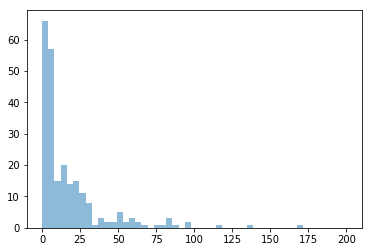

0 
max(counts)= 169 
Corresponding FAQ n :	 182 
FAQ: nethz password Dear xxx Thank you for your request. I have sent you a new Supernethz password to the desired address. Best regards, Your ID Team Caroline Stucki


In [45]:
# VISUALISATION
# here is the distribution of matches over FAQs: how many FAQs have one similar ticket, 
#two and so on, till the largest: 761 counts to Phishing mail warning
bins =  np.linspace(0, 200,50)
plt.hist(counts, bins,alpha=.5)
plt.show()
print(np.sum(counts>200), '\nmax(counts)=',max(counts),'\nCorresponding FAQ n :\t',unique[np.argmax(counts)],'\nFAQ:', faq_ans[unique[np.argmax(counts)]])

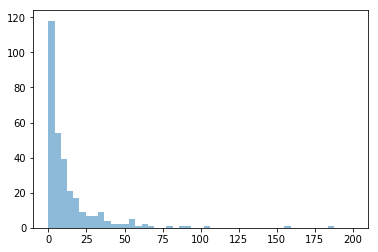

0 
max(counts)= 185 
Corresponding FAQ n :	 269 
FAQ:  Your request has been forwarded directly to your local departmental support group (ISG). Please note that the request is closed with us in the ticket system. If you have any further questions, please contact the ISG contacts of the departments.http: //www.id.ethz.ch/about/departments directly


In [20]:
# VISUALISATION
# here is the distribution of matches over FAQs: how many FAQs have one similar ticket, 
#two and so on, till the largest: 761 counts to Phishing mail warning
bins =  np.linspace(0, 200,50)
plt.hist(counts, bins,alpha=.5)
plt.show()
print(np.sum(counts>200), '\nmax(counts)=',max(counts),'\nCorresponding FAQ n :\t',unique[np.argmax(counts)],'\nFAQ:', faq_ans[unique[np.argmax(counts)]])

In [ ]:
# Let's now try to tag some tickets
# Per every % of similarity, let's issue a ticket and determine what category we would associate it with
# This will become a little biased test set

In [470]:
# WORK IN PROGRESS - IGNORE
SFT = np.copy(strength_FAQ_ticket)
old = 0.3
new = 0.2
SFT[SFT>old] = -1
indices = np.nonzero(SFT>new)
sample = random.sample(range(len(indices[0])), 1)
a = indices[0][sample]
b = np.argmax(SM[:,indices[0][sample]])
print(SFT[a],a,b)

[0.23976002] [2133] 113


In [479]:
# WORK IN PROGRESS - IGNORE
a=1676
b= 147
np.sum(strength_FAQ_ticket>0.3)/np.sum(strength_FAQ_ticket)

0.8197261014101455

In [477]:
# WORK IN PROGRESS - IGNORE
print("Similarity score: ", strength_FAQ_ticket[a])
print('\nTicket: ques:\t', ticket_ques[a], '\n\nans:\t', ticket_ans[a])
print('\n\nFAQ: ques:\t', faq_ques[b], '\n\nans:\t', faq_ans[b])

Similarity score:  0.3716538970262188

Ticket: ques:	 Hello, Have the PC newly set up and can not log in to nethz / VPN anymore. Before I request a new password, the username is &quot;andschmo&quot; and not &quot;andschmo@ethz.ch&quot;. Is that correct? Thanks, AndreasHello Joel, Thanks for your quick reply. I can log in on Idn / mail.ethz.ch. What I do not manage is the VPN download on sslvpn (print screen attached). I think I remember the password. Is the group correct too? For the download I need the VPN password not the idn / mail password - is that correct? Thank you for your help, Andreas 

ans:	 Dear Mr. Andreas Schmocker Your username is andschmo. But the password for nethz and VPN is not the same. Your ID Team Joel GreuterHello Andreas The group is right. And the VPN password must be used for login. If this is no longer known then it can be reset via [1] www.passwort.ethz.ch. Your ID Team Joel Greuter


FAQ: ques:	 I cannot login into the ETH Wifi 

ans:	  In case of a login p

In [ ]:
# TODO: this might no longer be valid since latest push
# GIVEN THIS REFERENCE
# validated pairs
List = np.zeros((1,2))
l = [481, 136]
List = np.concatenate((List, np.reshape(np.asarray(l),(1,2))), axis=0)
l = [2793, 172]
List = np.concatenate((List, np.reshape(np.asarray(l),(1,2))), axis=0)
l = [509, 261]
List = np.concatenate((List, np.reshape(np.asarray(l),(1,2))), axis=0)
l = [557, 261]
List = np.concatenate((List, np.reshape(np.asarray(l),(1,2))), axis=0)
l = [156, 172]
List = np.concatenate((List, np.reshape(np.asarray(l),(1,2))), axis=0)
l = [3874, 171]
List = np.concatenate((List, np.reshape(np.asarray(l),(1,2))), axis=0)
l = [1676, 147]